<a href="https://colab.research.google.com/github/Jorgellamocca/Cambio-Clim-tico/blob/main/cmip6_modelos_obs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACCESS-CM2 – Precipitación mensual Piura (Colab)

Flujo completo desde descarga CMIP6 hasta gráfica con Cartopy.

In [1]:
!pip install intake intake-esm xarray netcdf4 zarr cartopy shapely pyproj

In [2]:

import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:

cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)
cat


,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,61


In [4]:
MODELOS = {
    "ACCESS-ESM1-5": "r1i1p1f1",
    "CMCC-ESM2":     "r1i1p1f1",
    "CNRM-CM6-1":    "r1i1p1f2",
    "MRI-ESM2-0":    "r1i1p1f1",
    "NorESM2-MM":    "r1i1p1f1"
}

In [5]:
# ------------------------------------------------------------
# CARGA DE DATASETS
# ------------------------------------------------------------
datasets = {}

for modelo, member in MODELOS.items():
    print(f"Abriendo {modelo} ({member})...")

    cat_tmp = cat.search(
        activity_id="CMIP",
        source_id=modelo,
        experiment_id="historical",
        table_id="Amon",
        variable_id="pr",
        member_id=member
    )

    if len(cat_tmp.df) == 0:
        print(f"  ❌ {modelo}: no disponible")
        continue

    ds_dict = cat_tmp.to_dataset_dict(
        zarr_kwargs={"consolidated": False},
        storage_options={"token": "anon"},
        xarray_open_kwargs={"use_cftime": True}
    )

    datasets[modelo] = list(ds_dict.values())[0]
    print(f"  ✅ {modelo} cargado")

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado
Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado
Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado
Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado
Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado


In [21]:
# ------------------------------------------------------------
# DOMINIO PIURA
# ------------------------------------------------------------
dominio = dict(
    lat=slice(-8.5, -2.2),
    lon=slice(-92.5, -78.0)
)

# FECHA A GRAFICAR (SE DEFINE DESPUÉS)
FECHA = "1990-01"

proj = ccrs.PlateCarree()

Graficando ACCESS-ESM1-5...
ACCESS-ESM1-5 ('lat', 'lon') (5, 8)


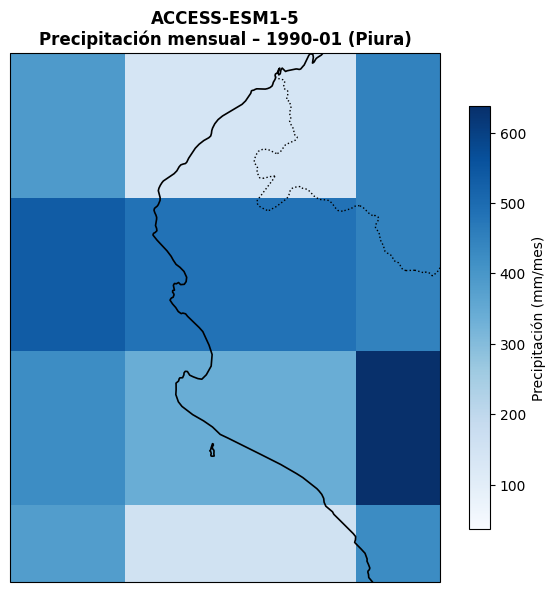

Graficando CMCC-ESM2...
CMCC-ESM2 ('lat', 'lon') (7, 12)


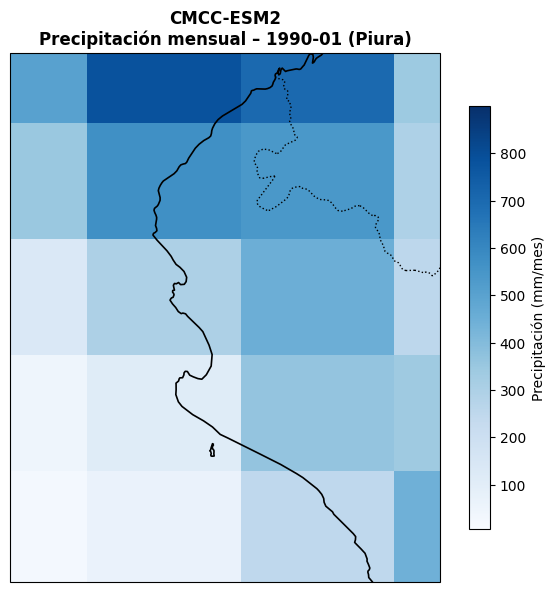

Graficando CNRM-CM6-1...
CNRM-CM6-1 ('lat', 'lon') (4, 10)


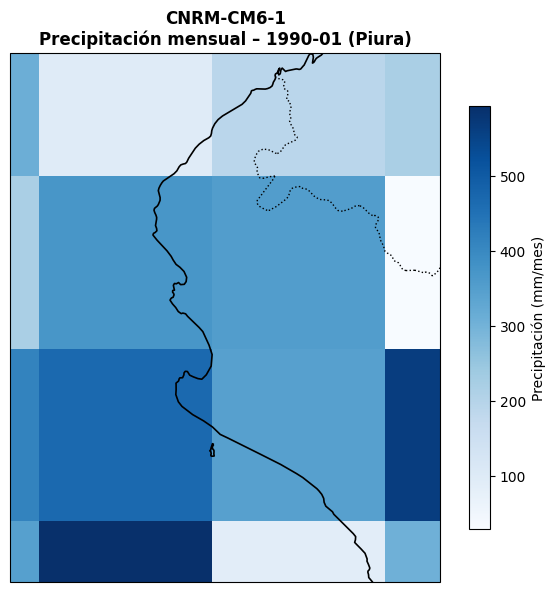

Graficando MRI-ESM2-0...
MRI-ESM2-0 ('lat', 'lon') (6, 13)


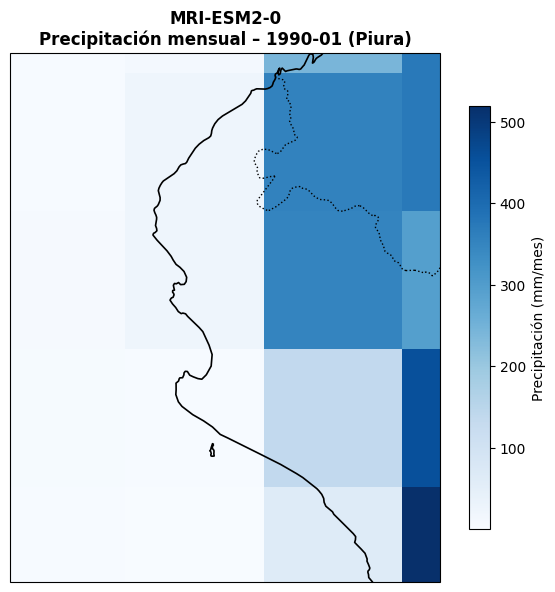

Graficando NorESM2-MM...
NorESM2-MM ('lat', 'lon') (7, 12)


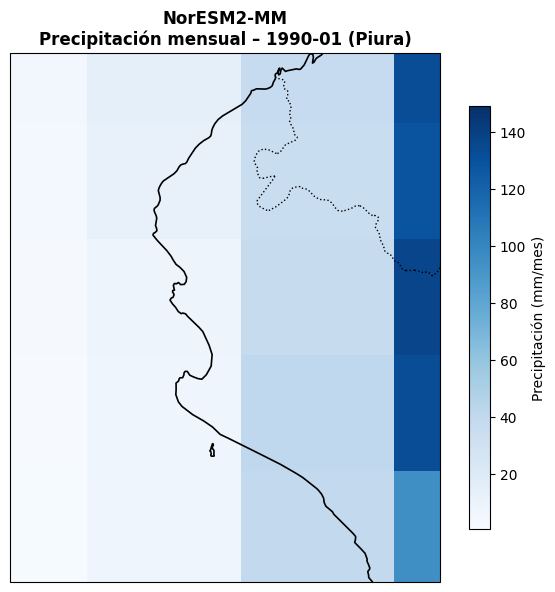

In [22]:
pr_por_modelo = {}   # contenedor por modelo

for modelo, ds in datasets.items():

    print(f"Graficando {modelo}...")

    # --------------------------------------------------------
    # 1. LONGITUDES 0–360 → -180–180
    # --------------------------------------------------------
    ds = ds.assign_coords(
        lon=((ds.lon + 180) % 360) - 180
    ).sortby("lon")

    # --------------------------------------------------------
    # 2. PRECIPITACIÓN MENSUAL (mm/mes)
    # --------------------------------------------------------
    days_in_month = ds.time.dt.days_in_month
    pr_modelo = ds["pr"] * 86400 * days_in_month
    pr_modelo.attrs["units"] = "mm/mes"

    # GUARDAR POR MODELO
    pr_por_modelo[modelo] = pr_modelo

    # --------------------------------------------------------
    # 3. RECORTE ESPACIAL
    # --------------------------------------------------------
    pr_area_mensual = pr_modelo.sel(**dominio)

    # --------------------------------------------------------
    # 4. SELECCIÓN FECHA + ELIMINAR DIMENSIONES EXTRA
    # --------------------------------------------------------
    pr_plot = (
        pr_area_mensual
        .sel(time=FECHA)
        .isel(
            member_id=0,
            dcpp_init_year=0
        )
        .squeeze()
    )

    # VERIFICACIÓN (OBLIGATORIA EN CMIP6)
    print(modelo, pr_plot.dims, pr_plot.shape)

    # --------------------------------------------------------
    # 5. GRAFICADO
    # --------------------------------------------------------
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=proj)

    ax.set_extent([-82.5, -79.0, -7.5, -3.2], crs=proj)


    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        pr_plot.lon,
        pr_plot.lat,
        pr_plot.values,
        cmap="Blues",
        shading="auto",
        transform=proj
    )

    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Precipitación (mm/mes)")

    ax.set_title(
        f"{modelo}\nPrecipitación mensual – {FECHA} (Piura)",
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()


In [ ]:
#LECTURA DE ERA5

In [13]:
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp > /dev/null 2>&1
!apt-get install -qq -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install -q cartopy shapely pyproj > /dev/null 2>&1


In [14]:
import xarray as xr
xr.backends.list_engines()

{'netcdf4': <NetCDF4BackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html,
 'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'scipy': <ScipyBackendEntrypoint>
   Open netCDF files (.nc, .cdf and .nc.gz) using scipy in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html,
 'kerchunk': <KerchunkBackend>
   Open Kerchunk References with Xarray
   Learn more at https://fsspec.github.io/kerchunk/,
 'pydap': <PydapBackendEntrypoint>
   Open remote datasets via OPeNDAP using pydap in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.PydapBackendEntrypoint.html,
 'store': <S

In [15]:
#Usar token registrado
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Permisos
!chmod 600 /root/.netrc

In [25]:

import xarray as xr
import pandas as pd

# -----------------------------
# Abrir dataset ERA5
# -----------------------------
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

In [26]:
#Longitudes 0–360 → -180–180
ds = ds.assign_coords(
    longitude=((ds.longitude + 180) % 360) - 180
).sortby("longitude")

In [27]:
# --- Conversión de tiempo ---
fechas = pd.to_datetime(ds.valid_time.values)

dias_mes = xr.DataArray(
    fechas.days_in_month,
    coords={"valid_time": ds.valid_time},
    dims=["valid_time"]
)

# --- Precipitación mensual (mm/mes) para TODOS los tiempos ---
pr_observado = ds.tp * 1000 * dias_mes
pr_observado.attrs["units"] = "mm/mes"

In [ ]:
#Cargar como ejmeplo para un punto de la titut y longitud dentro del area

In [28]:
LAT = -6.0
LON = -80.0

PERIODO = slice("1981-01", "2010-12")


In [29]:
# -----------------------------
# MODELO CMIP6
# -----------------------------
pr_cmip = pr_por_modelo["ACCESS-ESM1-5"]

# Selección temporal
pr_cmip_sel = pr_cmip.sel(time=PERIODO)

# Selección espacial (punto más cercano)
pr_cmip_point = pr_cmip_sel.sel(
    lat=LAT,
    lon=LON,
    method="nearest"
)

# Quitar dimensiones extra (CMIP6)
pr_cmip_point = (
    pr_cmip_point
    .isel(member_id=0, dcpp_init_year=0)
    .squeeze()
)

print("CMIP6 dims:", pr_cmip_point.dims)
print("CMIP6 periodo:",
      pr_cmip_point.time.min().values,
      pr_cmip_point.time.max().values)


CMIP6 dims: ('time',)
CMIP6 periodo: 1981-01-16 12:00:00 2010-12-16 12:00:00


In [30]:
pr_era5_sel = pr_observado.sel(valid_time=PERIODO)

pr_era5_point = pr_era5_sel.sel(
    latitude=LAT,
    longitude=LON,
    method="nearest"
)

# Renombrar tiempo para compatibilidad
pr_era5_point = pr_era5_point.rename(valid_time="time")

print("ERA5 dims:", pr_era5_point.dims)
print("ERA5 periodo:",
      pr_era5_point.time.min().values,
      pr_era5_point.time.max().values)


ERA5 dims: ('time',)
ERA5 periodo: 1981-01-01T00:00:00.000000000 2010-12-01T00:00:00.000000000


In [31]:
pr_cmip_aligned, pr_era5_aligned = xr.align(
    pr_cmip_point,
    pr_era5_point,
    join="inner"
)


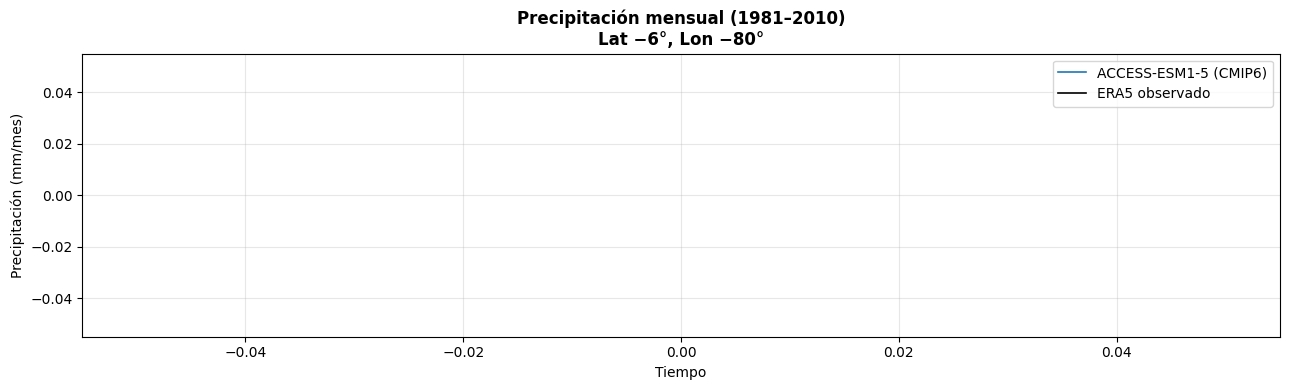

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 4))

plt.plot(
    pr_cmip_aligned.time,
    pr_cmip_aligned.values,
    label="ACCESS-ESM1-5 (CMIP6)",
    color="tab:blue",
    linewidth=1.2
)

plt.plot(
    pr_era5_aligned.time,
    pr_era5_aligned.values,
    label="ERA5 observado",
    color="black",
    linewidth=1.2
)

plt.title(
    "Precipitación mensual (1981–2010)\n"
    "Lat −6°, Lon −80°",
    fontweight="bold"
)

plt.ylabel("Precipitación (mm/mes)")
plt.xlabel("Tiempo")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [33]:
print("CMIP6 media 1981–2010 :", float(pr_cmip_aligned.mean()))
print("ERA5  media 1981–2010 :", float(pr_era5_aligned.mean()))
print("Sesgo (CMIP − ERA5)   :", float(pr_cmip_aligned.mean() - pr_era5_aligned.mean()))


CMIP6 media 1981–2010 : nan
ERA5  media 1981–2010 : nan
Sesgo (CMIP − ERA5)   : nan
